In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
#3 dfs
# data_g -> datos completos
# data_n -> datos sin leaders
# data_l -> datos solo leaders
data_g = pd.read_csv('../data/data_global.csv')
data_n = pd.read_csv('../data/data_no_leaders.csv')
data_l = pd.read_csv('../data/data_leaders.csv')

In [22]:
data_n['Engagement'].describe()

count    10226.000000
mean         2.990006
std          0.993117
min          0.000000
25%          2.520000
50%          3.070000
75%          3.600000
max          5.000000
Name: Engagement, dtype: float64

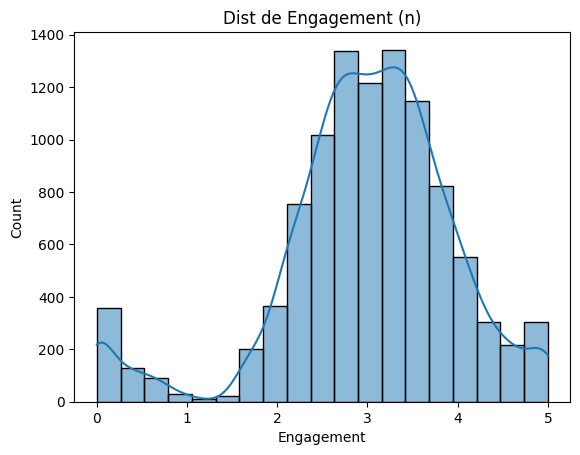

In [23]:
sns.histplot(data_n['Engagement'], bins=19, kde=True)
plt.title("Dist de Engagement (n)")
plt.show()

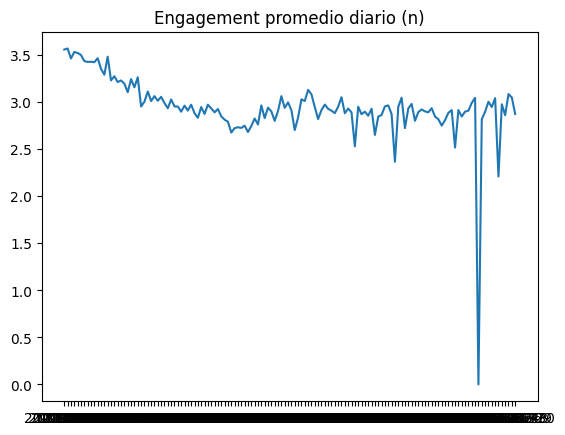

In [24]:
# Promedio diario por fecha
eng = (data_n.groupby('DateDT')['Engagement'].mean().reset_index())

plt.plot(eng['DateDT'], eng['Engagement'])
plt.title("Engagement promedio diario (n)")
plt.show()

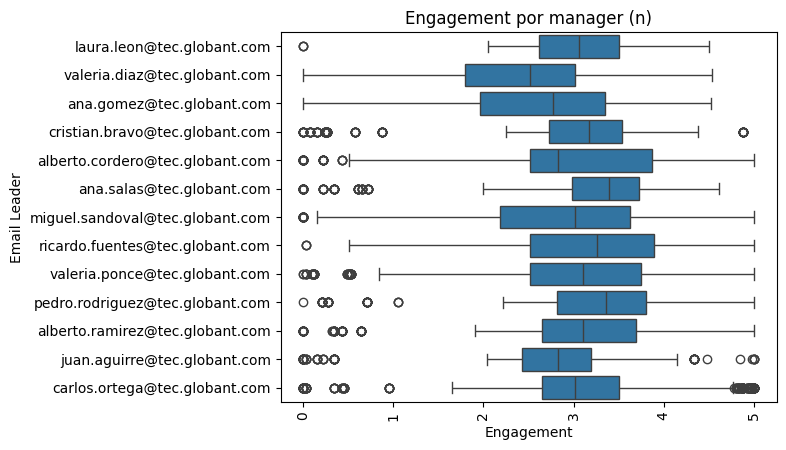

In [25]:
sns.boxplot(y="Email Leader", x='Engagement', data=data_n)
plt.title("Engagement por manager (n)")
plt.xticks(rotation=90)
plt.show()

In [26]:
data_n.dropna(inplace=True)

In [27]:
data_g["DateDT"] = pd.to_datetime(data_g["DateDT"])
data_n["DateDT"] = pd.to_datetime(data_n["DateDT"])
data_l["DateDT"] = pd.to_datetime(data_l["DateDT"])

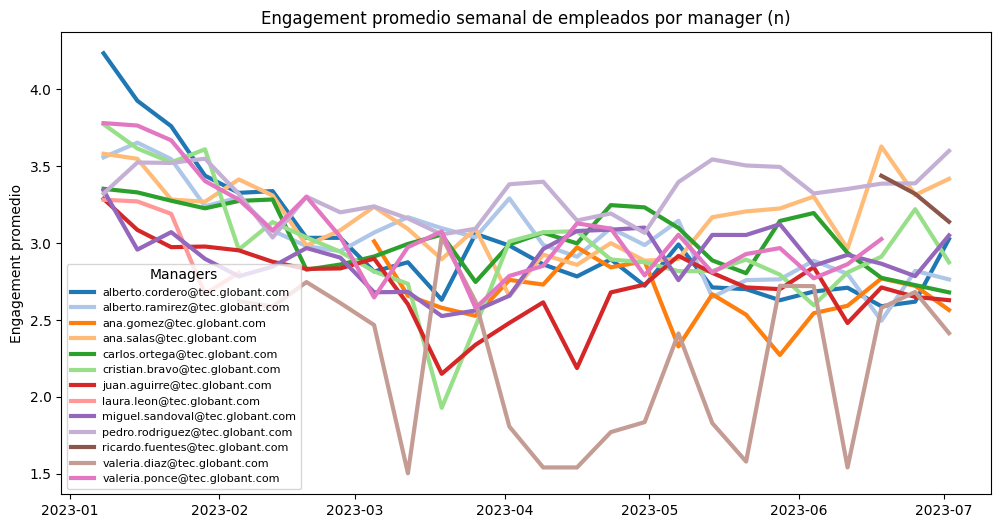

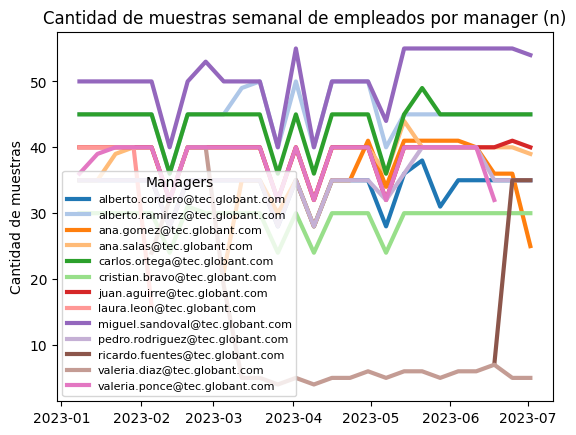

In [35]:
eng_mgr = (
    data_n
    .set_index("DateDT")
    .groupby("Email Leader")
    .resample("W")
    .agg(
        mean_eng=("Engagement", "mean"),
        n_scores=("Engagement", "size")
    )
    .reset_index()
)

managers = eng_mgr["Email Leader"].unique()
palette = sns.color_palette("tab20", n_colors=len(managers))
color_map = dict(zip(managers, palette))

plt.figure(figsize=(12,6))

for mid, df_m in eng_mgr.groupby("Email Leader"):
    plt.plot(
        df_m["DateDT"], 
        df_m["mean_eng"],        
        linewidth=3,
        alpha=1,
        color=color_map[mid],
        label=str(mid)
    )

plt.title("Engagement promedio semanal de empleados por manager (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Managers", fontsize=8)
plt.show()


for mid, df_m in eng_mgr.groupby("Email Leader"):
    plt.plot(
        df_m["DateDT"], 
        df_m["n_scores"],        
        linewidth=3,
        alpha=1,
        color=color_map[mid],
        label=str(mid)
    )

plt.title("Cantidad de muestras semanal de empleados por manager (n)")
plt.ylabel("Cantidad de muestras")
plt.legend(title="Managers", fontsize=8)
plt.show()

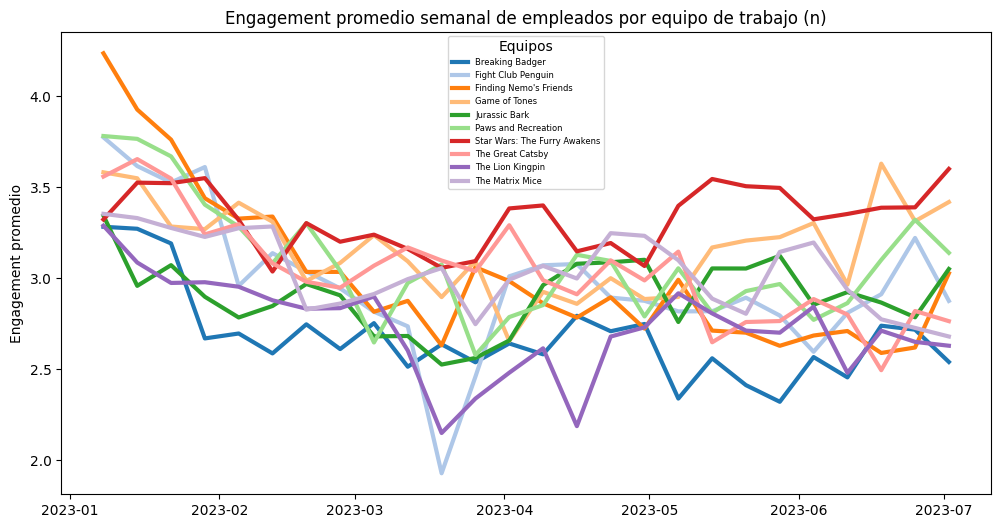

In [ ]:
# Promedio por fecha y Equipo (semanal)
eng_mgr = (data_n.set_index('DateDT').groupby('Team Name')['Engagement']
           .resample('W').mean().reset_index()) # W para que sea semanal (quitar ruido)


teams = eng_mgr['Team Name'].unique()
palette = sns.color_palette("tab20", n_colors=len(teams))
color_map = dict(zip(teams, palette))

plt.figure(figsize=(12,6))

for mid, df_m in eng_mgr.groupby('Team Name'):
    plt.plot(df_m['DateDT'], df_m['Engagement'], alpha=1, linewidth=3, color=color_map[mid], label=str(mid)) # para que no tape todo

plt.title("Engagement promedio semanal de empleados por equipo de trabajo (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Equipos", fontsize=6)
plt.show()

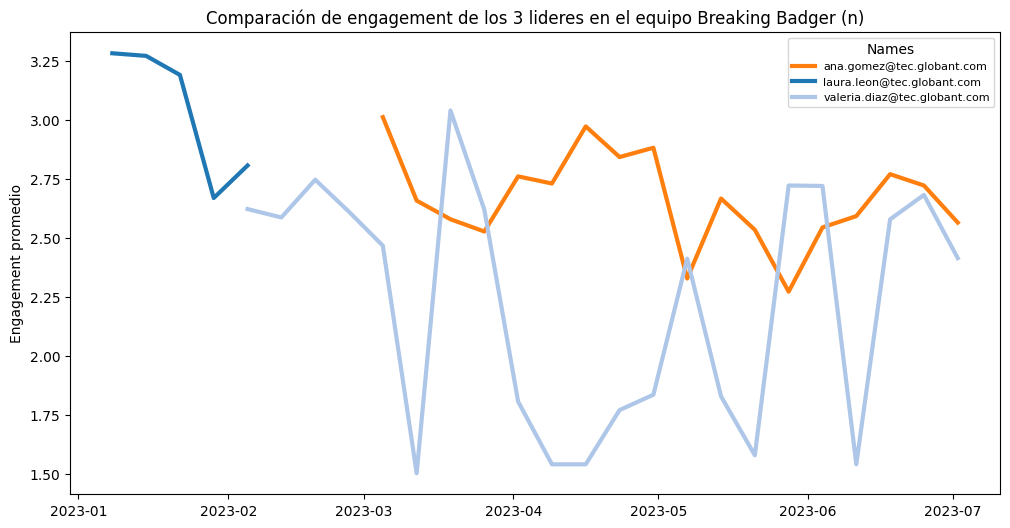

In [ ]:
Lideres_a_comparar = ["laura.leon@tec.globant.com", "valeria.diaz@tec.globant.com", "ana.gomez@tec.globant.com"]
# Promedio por fecha y manager (semanal)
eng_mgr = (data_n.set_index('DateDT').groupby('Email Leader')['Engagement']
           .resample('W').mean().reset_index()) # W para que sea semanal (quitar ruido)


managers = eng_mgr['Email Leader'].unique()
palette = sns.color_palette("tab20", n_colors=len(managers))
color_map = dict(zip(managers, palette))


df_filtro = eng_mgr[ eng_mgr["Email Leader"].isin(Lideres_a_comparar) ]

palette = sns.color_palette("tab20", n_colors=len(Lideres_a_comparar))
color_map = dict(zip(Lideres_a_comparar, palette))

plt.figure(figsize=(12,6))

for team, df_m in df_filtro.groupby("Email Leader"):
    plt.plot(df_m["DateDT"], df_m["Engagement"],
             linewidth=3, alpha=1,
             color=color_map[team],
             label=team)

plt.title("Comparación de engagement de los 3 lideres en el equipo Breaking Badger (n)")
plt.ylabel("Engagement promedio")
plt.legend(title="Names", fontsize=8)
plt.show()


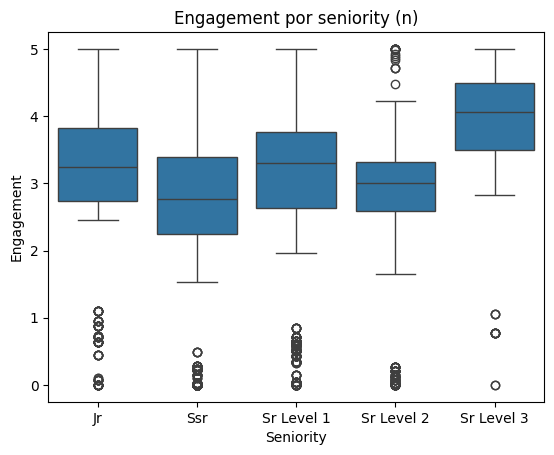

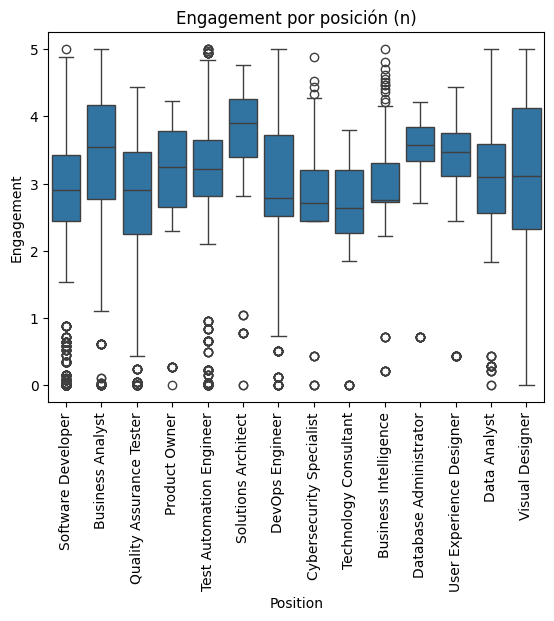

In [ ]:
sns.boxplot(x='Seniority', y='Engagement', data=data_n)
plt.title("Engagement por seniority (n)")
plt.show()

sns.boxplot(x='Position', y='Engagement', data=data_n)
plt.title("Engagement por posición (n)")
plt.xticks(rotation=90)
plt.show()

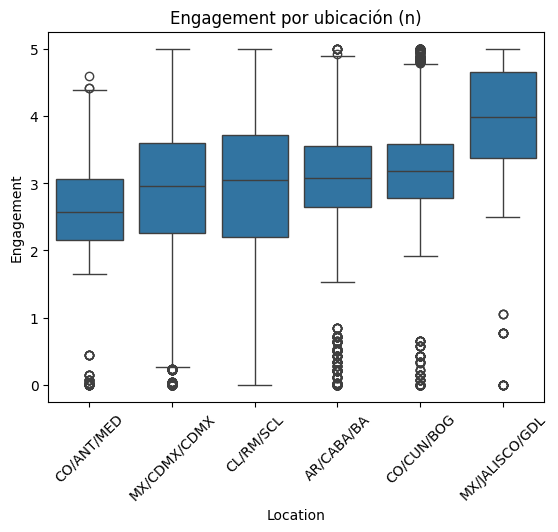

In [ ]:
sns.boxplot(x='Location', y='Engagement', data=data_n)
plt.title("Engagement por ubicación (n)")
plt.xticks(rotation=45)
plt.show()

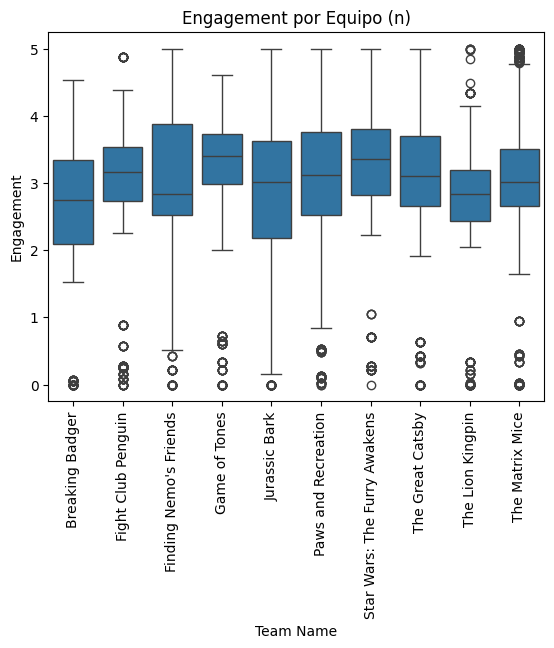

In [ ]:
sns.boxplot(x='Team Name', y='Engagement', data=data_n)
plt.title("Engagement por Equipo (n)")
plt.xticks(rotation=90)
plt.show()